# Introduction

Language is complex. Just a few words can convey intense feelings. Some may argue that Twitter tweets are toxic. Is that really the case? Can we train machine learning models to predict the overall sentiment of just a few words in a tweet? 

We are studying a dataset of [Sentiment with 1.6 million tweets with locations](https://www.kaggle.com/datasets/vivekchary/sentiment-with-16-million-tweets-with-locations) found on Kaggle. This dataset consists of 1.6 million tweets from 2009-2017. A majority of these tweets are in English, and they originate from 33 different countries (approximately evenly distributed within the dataset). Each tweet also has a labeled sentiment score, with 0 = negative, 2 = neutral, and 4 = positive.

Our research question consists of two parts: Can we accurately predict the sentiment of a tweet, and does the location of a tweet influence sentiment?

# Methods and Metrics

Before getting into the models, we found that 1.6 million tweets is a lot to parse. We chose to use a sample of this dataset by shuffling (for randomness) and splitting (using 5 parts) to get a smaller dataset of 320,000 tweets. 

We tested three different models on this smaller dataset: a TextBlob Naive Bayes model, a Natural Language ToolKit pre-trained analyzer using VADER, and a Hugging Face Transformer using BERTweet (a RoBERTa model trained on English tweets.)

First, import all functions in `helper_functions.py` by running the code below.



In [1]:
from helper_functions import *

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Below is how we processed our 1.6 million tweets into a managable chunk. Note that we drop a few unnecessary column titles like id, date, flag, and user.

In [2]:
# our downloaded data file is in the folder data/
df = pd.read_csv("data/sentiment140_with_location.csv", names=['target','id','date','flag','user','text', 'location']) 
shuffled = df.sample(frac = 1)
result = np.array_split(shuffled, 5)
split_df = result[0]
split_df = split_df.drop(['id', 'date', 'flag', 'user'], axis=1)
split_df

c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,target,text,location
1195392,4,41 days until @sebastianhull and I are united,New Zealand
223146,0,I bet that now since I'm on nothing awesome wi...,Antarctica
85808,0,"right, this isn't get the chores done ... off ...",India
461369,0,this darn insomnia.... and i can't even do any...,Italy
980389,4,"@KekonaGirl $10, so I am offering it to you fo...",Italy
...,...,...,...
383364,0,@shaundiviney @andyclemmensen @shaunjumpnow . ...,Antarctica
165483,0,So I cannot find my poetry book. It wasn't at ...,Chile
70385,0,@j4smyne why not? what else you got thats bett...,Germany
487727,0,what to do! i need to go out somewhere. too ba...,Chile


## Naive Bayes

The first model we used was a Naive Bayes classifier from the Textblob library. The Naive Bayes classifier is a supervised machine learning binary classifier that is based on probability. To use this classifier, we trained the model on a portion of our dataset for a given country. This entailed getting all of the tweets for a country, splitting our dataset in a train test split, which was about 80% train and 20% test. Each example used in training has a "pos" or "neg" label along with the tweet text. After training, we give our model an example from the test set, have it predict the sentiment based on the text, and then we compare the predicted sentiment to the actual sentiment label. We wanted to use the Naive Bayes classifier because we wanted to train our own model and learned about it in class. Note that each classifier we train is based on tweets and sentiment for a given country. Below is the code to train and test the classifier for tweets in the USA.  


In [3]:
dataset = getLocationTweetsWithSentiment(split_df, "USA")
train = dataset[:int(0.8*len(dataset))]
test = dataset[int(0.8*len(dataset)):]

In [3]:
# Naive Bayes Classifier
cl = NaiveBayesClassifier(train) # train needs tuples of text and pos/neg
correct = 0
for text, sentiment in test:
    pred = cl.classify(text)
    correct += (pred == sentiment)
print(correct/len(test))

0.7417864476386037


From the code above, we can see that the Naive Bayes classifier that is trained on our data got an accuracy of about 74%. 

## NLTK Sentiment Intensity Analyzer

The second model that we used was the [Natural Language ToolKit Sentiment Intensity Analyzer](https://realpython.com/python-nltk-sentiment-analysis/). This model is a pre-trained sentiment analyzer using VADER (Valence Aware Dictionary and sEntiment Reasoner). We chose this model because we wanted to see how accurate a pre-trained sentiment analyzer would be on our dataset. This pre-trained analyzer also works best on small snippets of text from social media, like tweets! To use this model, run the following commands. First, usenload necessary resources for the SIA model: pip to install NLTK in your terminal:
dow

In [4]:
nltk.download([
    "names",
    "stopwords",
    "state_union",
    "twitter_samples",
    "movie_reviews",
    "averaged_perceptron_tagger",
    "vader_lexicon",
    "punkt"])

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\jhsin\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jhsin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to
[nltk_data]     C:\Users\jhsin\AppData\Roaming\nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\jhsin\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\jhsin\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jhsin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up

True

Next, create a SentimentIntensityAnalyzer and find sentiment scores for text. We looped through the tweets in `test` and used the polarity_scores() function to find sentiment scores. 

polarity_scores() returns a dictionary with the keys `pos` (positive score), `neg` (negative score), `neu` (neutral score), and `compound` (compounded score). The scores of `pos`, `neg`, and `neu` add up to 1, and `compound` is a combination of the previous keys such that it equals 0 if the overall score is neutral, <0 if the overall score is negative, and >0 if the overall score is positive.

In the following code snippet, We use the value of `compound` to determine the sentiment score and compare this with the actual labeled score to get the accuracy of this model. 

In [6]:
sia = SentimentIntensityAnalyzer()
correct = 0

for text, sentiment in test:
    sia_pred = sia.polarity_scores(text)
    if sia_pred["compound"] < 0:
        pred = "neg"
    elif sia_pred["compound"] > 0:
        pred = "pos"
    else:
        pred = "neu"
    correct += (pred == sentiment)

print("SIA accuracy:", correct/len(test))

SIA accuracy: 0.5161621344279117


As you can see, our SIA model performs significantly worse than our Naive Bayes model.



## Hugging Face Transformer

The final model that we looked at was a Hugging Face Transformer built off of [BERTweet](https://github.com/VinAIResearch/BERTweet), a RoBERTa model trained on English tweets. This model is trained with SemEval 2017 corpus, which includes around 40,000 tweets. We chose to use this model because it was built specifically for tweets, and we wanted to see if another pre-trained model would yield similar results as our NLTK SIA model. This model takes in an array of strings to analyze and returns an array of dictionaries of the same length. Each dictionary has exactly two items, a `label` that signifies the sentiment and can equal `POS`, `NEG`, or `NEU`, and a `score` that represents the certainty probability of the label. To use this model, run the following steps:

In [7]:
specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

# get array of strings to analyze
hf_test = test[:128]
data = [text for text, sentiment in hf_test]

# store results of model
results = specific_model(data)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Now we interate through results to find the accuracy of the model. 

In [8]:
correct = 0

for i in range(len(results)):
    pred = results[i]['label'].lower()
    sentiment = hf_test[i][1]
    correct += (pred == sentiment)

print("HF accuracy:", correct/len(hf_test))

HF accuracy: 0.5234375


The accuracy of the Hugging Face transformer is also significantly lower than our Naive Bayes model, and is comparable to the accuracy of our SIA model. 

## Results

Overall, the results suggest that Naive Bayes is the most accurate model, with roughly 70% accuracy. SIA and hugging face got roughly 50% accuracy. It's interesting how the pre-trained models both scored so poorly and so similarly, and we believe that the structure of the dataset is the culprit. 

The dataset labels each tweet with a sentiment of either 0 (negative) or 4 (positive), with no 2 (neutral) labels. The pre-trained models both predict around 25-30% of their test data to be neutral, and we believe that this difference causes a significant change in accuracy for the models. 

We also believe that the dataset contains mislabeled tweets (e.g. tweets given a positive score despite being clearly negative) just from a quick look through of the dataset. This might cause the pre-trained models to score worse than what they actually would score.

Below we show three different graphs, each representing the average predicted sentiment for four countries' tweets, using the classifiers. The first uses the Naive Bayes classifier and we can compare the actual sentiment to the predicted sentiment for USA, China, Spain, and Canada.

In [9]:
# General data used by all models in plotting
locations = ["USA", "China", "Spain", "Canada"]
data = getSortedLocationScores(split_df)

actual_sentiments = {
    'USA': data["USA"],
    'China': data["China"],
    'Spain': data["Spain"],
    'Canada': data["Canada"]}

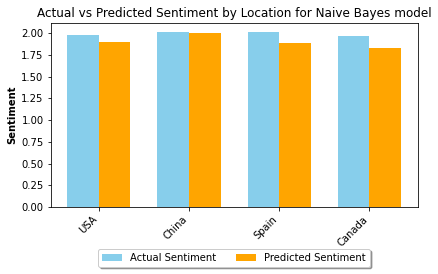

In [4]:
# Naive Bayes
predicted_sentiments_nb = {
    'USA': averageSentimentByLocation("USA", split_df),
    'China': averageSentimentByLocation("China", split_df),
    'Spain': averageSentimentByLocation("Spain", split_df),
    'Canada': averageSentimentByLocation("Canada", split_df)
}

plot_grouped_bar(locations, actual_sentiments, predicted_sentiments_nb, "Naive Bayes")

From the graph above, we see how Naive Bayes compares to the actual average sentiment of the locations from the dataset. It appears that the predicted sentiment lean more towards an average of less than 2, suggesting that more of its predictions are negative rather than positive. However, it is clear that most of the results for the average sentiment for these locations is generally neutral, and is quite close to the actual average sentiment. Since this model is trained on the dataset, this result is not very surprising.

Next, we plot the actual and predicted sentiment by location for the NLTK Sentiment Intensity Analyzer model.

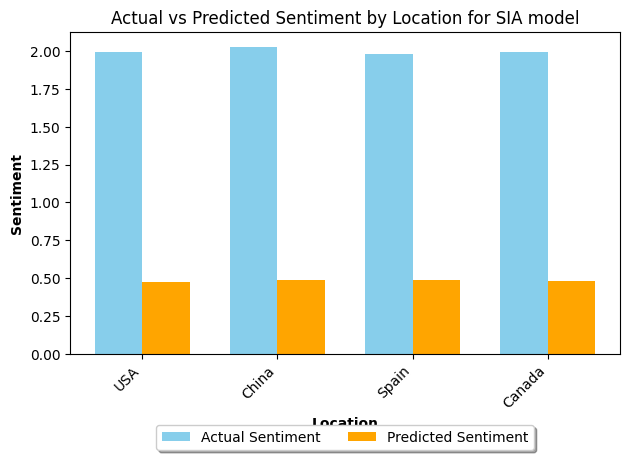

In [10]:
# Sentiment Intensity Analyzer
predicted_sentiments_sia = {
    'USA': averageSentimentByLocation_sia("USA", split_df),
    'China': averageSentimentByLocation_sia("China", split_df),
    'Spain': averageSentimentByLocation_sia("Spain", split_df),
    'Canada': averageSentimentByLocation_sia("Canada", split_df)
}

plot_grouped_bar(locations, actual_sentiments, predicted_sentiments_sia, "SIA")

The predicted sentiment scores for SIA are much lower than the actual sentiment scores across the four locations. As discussed for the accuracy of this model, we think that the lower sentiment prediction is a result of neutral labels for tweets that are actually labeled 'positive'. The neutral labels may be the reason that the average sentiment prediction is much lower. 

Next, we repeat the plots for the Hugging Face Transformer model:

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


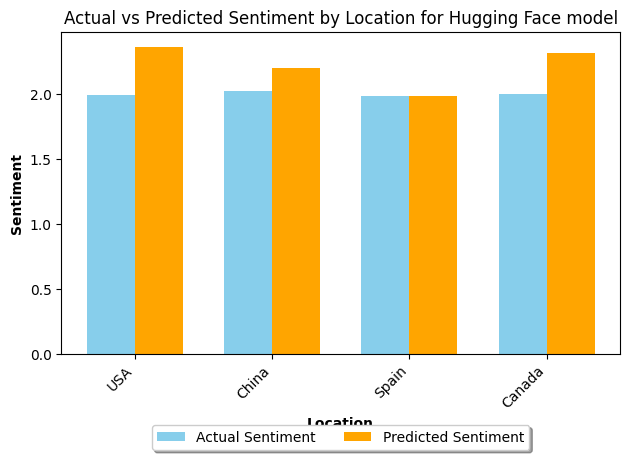

In [11]:
# Hugging Face Transformer
predicted_sentiments_hf = {
    'USA': averageSentimentByLocation_hf("USA", split_df),
    'China': averageSentimentByLocation_hf("China", split_df),
    'Spain': averageSentimentByLocation_hf("Spain", split_df),
    'Canada': averageSentimentByLocation_hf("Canada", split_df)
}

plot_grouped_bar(locations, actual_sentiments, predicted_sentiments_hf, "Hugging Face")

Surprisingly, the predicted sentiment of the Hugging Face transformer is generally higher than the actual sentiment! This pre-trained model overfitted, despite also having neutral labels. We believe this means that the tweets that the model labeled as 'neutral' were actually labeled 'negative', leading to a higher average predicted sentiment.

In conclusion, we found that it's hard to predict sentiment! From dataset faults to differences between models, sentiment is hard to accurately predict. We also found that location doesn't have a significant impact on average sentiment. We only showed results for 4 different countries in this notebook, but we've compared results across all countries and there wasn't a clear distinction of which country may have the most positivity or negativity in tweets. 

# Sources

- https://www.kaggle.com/datasets/vivekchary/sentiment-with-16-million-tweets-with-locations
- https://textblob.readthedocs.io/en/dev/api_reference.html#module-textblob.en.sentiments
- https://realpython.com/python-nltk-sentiment-analysis/
- https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis
